In [1]:
import numpy as np
from scipy import sparse
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.gridspec import GridSpec

from tools import compute_marginals, compute_means, monitor_progress, pearson_residuals, remove_rare_genes
from nb_regression_R import extract_errors, extract_warnings, r_glmPoisson_MLtheta, r_MLtheta

### Load preprocessed PBMC data

In [3]:
with open('datasets/33k_pbmc/preprocessed.pickle','rb') as f:
    pmbc = pickle.load(f)
counts_orig = pmbc['counts'].toarray()

In [4]:
ns_orig,ps_orig = compute_marginals(counts_orig)
means_orig,mean_min_orig,mean_max_orig,mean_range_orig = compute_means(counts_orig)

### Simulate control data with $\theta = 10$

In [5]:
theta_nbsim = 10

In [6]:
%%time
np.random.seed(42)
mu_nbsim = ns_orig[:, np.newaxis] @ ps_orig[np.newaxis]  
p_nbsim = theta_nbsim / (theta_nbsim + mu_nbsim)
counts_nbsim_raw = np.random.negative_binomial(theta_nbsim, p_nbsim)

CPU times: user 1min 5s, sys: 7.33 s, total: 1min 12s
Wall time: 1min 12s


In [7]:
counts_nbsim,genes_nbsim = remove_rare_genes(counts_nbsim_raw,pmbc['genes'], minimum_detected_cells_per_gene = 5)
ns_nbsim,ps_nbsim = compute_marginals(counts_nbsim)
means_nbsim,mean_min_nbsim,mean_max_nbsim,mean_range_nbsim = compute_means(counts_nbsim)

Of 16806 total genes, returning 16469 genes that are detected in 5 or more cells.
Output shape: (33148, 16469)


### Fit NB regression models

In [8]:
def fit_overspecified_model(counts,depths,name,thetaML_max_iter=10):
    '''for all genes, fit NB regression as Hafemeister&Satija (2019), saving results to file'''
    
    n_genes = counts.shape[1]
    log10_depths = np.log10(depths)    

    
    beta0s = np.zeros((n_genes)) * np.nan
    beta1s = np.zeros((n_genes)) * np.nan
    thetas = np.zeros((n_genes)) * np.nan
    warning_msgs_R = n_genes * [['"fitting error"']]
    errors = n_genes * [None]
    
    for gene_id in range(n_genes):
        
        try:         
            beta0,beta1,theta, warning_msg_R = r_glmPoisson_MLtheta(x=log10_depths,y=counts[:,gene_id],thetaML_max_iter=thetaML_max_iter)
            beta0s[gene_id] = beta0
            beta1s[gene_id] = beta1
            thetas[gene_id] = theta            
            warning_msgs_R[gene_id] = warning_msg_R

        except Exception as error:

            errors[gene_id] = dict(gene_id=gene_id,error=error)
         
        monitor_progress(gene_id,n_genes)

    res = dict(beta0s=beta0s,
               beta1s=beta1s,
               thetas=thetas,
               warning_msgs=extract_warnings(warning_msgs_R),
               errors=extract_errors(errors))

    np.save('fit_results/fit_overspecified_maxIterTheta%u_%s' % (thetaML_max_iter,name),res)

In [9]:
def fit_offsetmodel_w_statsmodel(counts,depths,name):
    '''use statsmodel to fit offsetmodel (Eq. 3) and obtain beta0 (intercept) estimates, saving results to file'''
    n_cells = counts.shape[0]
    n_genes = counts.shape[1]    
    
    ##np.ones: will fit intercept beta0
    X = np.ones((n_cells,1))
    ##log(depths): will be used as offsets
    logdepths = np.log(depths)

    beta0 = np.zeros(n_genes) * np.nan
    for gene_id in range(n_genes):        
        offsetmodel = sm.Poisson(counts[:,gene_id], X, offset = logdepths)
        result = offsetmodel.fit(disp=0)
        beta0[gene_id] = result.params
        
        monitor_progress(gene_id,n_genes)


    res = dict(beta0=beta0)
    np.save('fit_results/fit_offsetmodel_w_statsmodel_%s' % (name),res)

In [10]:
#2h20min
fit_overspecified_model(counts_orig,ns_orig,name='pmbc_hafemeister_satija_reproduction')
#2h30min
fit_overspecified_model(counts_nbsim,ns_nbsim,name='pmbc_simulation_theta%s' % (theta_nbsim))
#4h50min
fit_overspecified_model(counts_nbsim,ns_nbsim,name='pmbc_simulation_theta%s' % (theta_nbsim),thetaML_max_iter=100)

In [11]:
#40min
fit_offsetmodel_w_statsmodel(counts_orig,ns_orig,name='pmbc')

#### Load and process fit results

In [12]:
def fix_diverged_thetas(fit,clipping_threshold,log10jittersize,verbose):
    '''Sets diverged theta estimates to a large value and adds jitter'''
    
    thetas = fit['thetas']
    errors =np.array(fit['errors'])

    thetas_large_idx = thetas > clipping_threshold
    n_thetas_large = np.sum(thetas_large_idx)
    thetas[thetas_large_idx] = 10**(np.log10(clipping_threshold) + (np.random.random_sample(size=(n_thetas_large))*log10jittersize))

    inf_errortypes = ['Error in while ((it <- it + 1) < limit && abs(del) > eps) { : \n  missing value where TRUE/FALSE needed\nCalls: <Anonymous> -> <Anonymous> -> theta.ml\n',
                      'Error in while ((it <- it + 1) < limit && abs(del) > eps) { : \n  missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n',
                      'Error in if (t0 < 0) { : missing value where TRUE/FALSE needed\nCalls: <Anonymous> -> <Anonymous> -> theta.ml\n',
                      'Error in if (t0 < 0) { : missing value where TRUE/FALSE needed\nCalls: <Anonymous> ... <Anonymous> -> withWarnings -> withCallingHandlers -> theta.ml\n']    
    
    inf_errors_idx = np.isin(errors,inf_errortypes)
    n_inf_errors = np.sum(inf_errors_idx)
    thetas[inf_errors_idx] = 10**(np.log10(clipping_threshold) + (np.random.random_sample(size=(n_inf_errors))*log10jittersize))
    
    if verbose:
        print('Clipping %u / %u theta estimates to %u plus noise (because of %u inf divergence errors and %u superlarge estimates).\n %u nans left afterwards.' % (n_inf_errors+n_thetas_large,len(thetas),clipping_threshold,n_inf_errors,n_thetas_large,sum(np.isnan(thetas))))
    
    return thetas

In [13]:
#load all fits
fitfile_orig = 'fit_results/fit_overspecified_maxIterTheta10_pmbc_hafemeister_satija_reproduction.npy'
fitfile_offset_orig = 'fit_results/fit_offsetmodel_w_statsmodel_pmbc.npy'
fitfile_nbsim_iter10 = 'fit_results/fit_overspecified_maxIterTheta10_pmbc_simulation_theta%s.npy' % (theta_nbsim)
fitfile_nbsim_iter100 = 'fit_results/fit_overspecified_maxIterTheta100_pmbc_simulation_theta%s.npy' % (theta_nbsim)

fit_orig = np.load(fitfile_orig,allow_pickle=True).item()
fit_offset_orig =  np.load(fitfile_offset_orig,allow_pickle=True).item()
fit_nbsim_iter10 =  np.load(fitfile_nbsim_iter10,allow_pickle=True).item()
fit_nbsim_iter100 =  np.load(fitfile_nbsim_iter100,allow_pickle=True).item()

#unpack for panel a,b,c
beta0_orig = fit_orig['beta0s']
beta1_orig = fit_orig['beta1s']
theta_orig = fit_orig['thetas']

#unpack for panel e
beta0_offset_orig = fit_offset_orig['beta0']

#unpack for panel f
theta_nbsim_iter10 = fit_nbsim_iter10['thetas']

#unpack and apply clipping function for panel g
fit_dict = dict(errors=fit_nbsim_iter100['errors'])
fit_dict['thetas']=fit_nbsim_iter100['thetas']
theta_nbsim_iter100_clipped = fix_diverged_thetas(fit_dict,clipping_threshold = 10**6,log10jittersize=0.5,verbose=True)

Clipping 8384 / 16469 theta estimates to 1000000 plus noise (because of 6670 inf divergence errors and 1714 superlarge estimates).
 0 nans left afterwards.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


### Compute correlation between slope and intercept for overspecified model

In [15]:
np.corrcoef(beta0_orig,beta1_orig)

array([[ 1.        , -0.91278422],
       [-0.91278422,  1.        ]])

### Compute residuals analytically and mark genes H&S identified as variable

In [16]:
%%time
residual_theta = 100
residuals_orig = pearson_residuals(counts_orig,residual_theta)
residual_var_orig = np.var(residuals_orig,axis=0)

CPU times: user 12.1 s, sys: 2.75 s, total: 14.8 s
Wall time: 14.8 s


In [17]:
variable_genes_orig = ['TUBB1','CLU','PTGDS','GNG11','SDPR','PF4','PPBP','HIST1H2AC','MZB1','IGJ','IGLL5','GZMB','GNLY','S100A8','NKG7','S100A9','CCL5','LYZ','FTL','FTH1']
variable_genes_orig_idx = np.isin(pmbc['genes'],variable_genes_orig)

## Figure 1

In [18]:
dotsize=3
#for broken lines
linewidth_broken = 2
color_broken = 'tab:red'
#axis limits
xlim_satija = [1e-4,1e2]
ylim_satija_theta = [10**-7.5,10**1.5]
ylim_satija_beta0 = [-60,20]
title_fontsize = 22
title_fontweight = "bold"
title_position = (-0.2,0.9)
title_location = 'center'
title_y_padding = -10
markerfirst = True

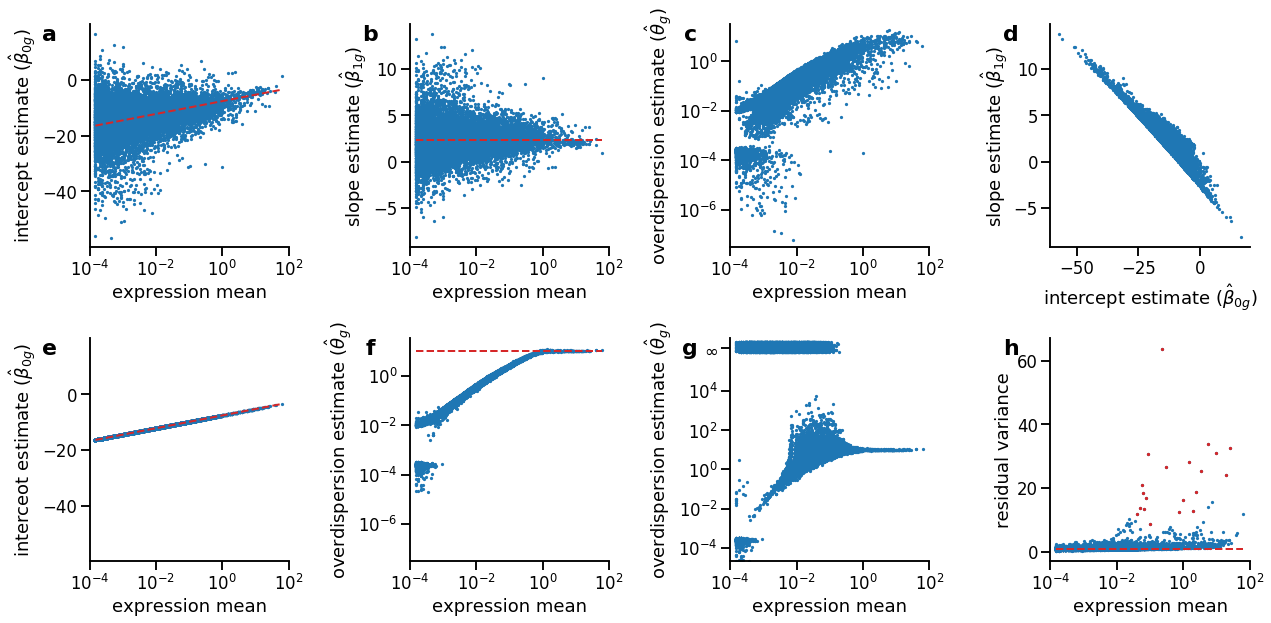

In [19]:
with sns.plotting_context("talk"):


    fig = plt.figure(figsize=(18,9)) #constrained_layout=True)

    gs = GridSpec(2, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])  #beta0
    ax2 = fig.add_subplot(gs[0, 1])  #beta1
    ax3 = fig.add_subplot(gs[0, 2])  #theta
    ax4 = fig.add_subplot(gs[0, 3])  #correlation    
    ax5 = fig.add_subplot(gs[1, 0])  #offset beta0
    ax6 = fig.add_subplot(gs[1, 1])  #theta sim
    ax7 = fig.add_subplot(gs[1, 2])  #theta sim with niter=100
    ax8 = fig.add_subplot(gs[1, 3])  #residuals



    ax1.set_title('a',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax1.scatter(means_orig, beta0_orig, s=dotsize)
    ax1.set_xscale('log')
    ax1.set_ylabel(r'intercept estimate ($\hat\beta_{0g}$)')
    ax1.set_xlabel('expression mean')
    beta0_prediction = np.log(mean_range_orig / np.mean(ns_orig))
    ax1.plot(mean_range_orig,beta0_prediction, '--',c=color_broken, linewidth=linewidth_broken)
    ax1.set_xlim(xlim_satija)
    ax1.set_ylim(ylim_satija_beta0)
    ax1.set_yticks(ax1.get_yticks()[1:-1])
    
    ax2.set_title('b',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax2.scatter(means_orig, beta1_orig, s=dotsize)    
    ax2.set_xscale('log')
    ax2.set_ylabel(r'slope estimate ($\hat\beta_{1g}$)')
    ax2.set_xlabel('expression mean')    
    ax2.hlines(np.log(10),mean_min_orig,mean_max_orig,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    ax2.set_xlim(xlim_satija)
    
    ax3.set_title('c',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax3.scatter(means_orig, theta_orig, s=dotsize)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel(r'overdispersion estimate ($\hat\theta_{g}$)')
    ax3.set_xlabel('expression mean')
    ax3.set_ylim(ylim_satija_theta)
    ax3.set_xlim(xlim_satija)

    ax4.set_title('d',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax4.scatter(beta0_orig,beta1_orig,s=dotsize)
    ax4.set_xlabel(r'intercept estimate ($\hat\beta_{0g}$)')
    ax4.set_ylabel(r'slope estimate ($\hat\beta_{1g}$)')

    ax5.set_title('e',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax5.scatter(means_orig,beta0_offset_orig,s=dotsize)
    ax5.plot(mean_range_orig,beta0_prediction,'--',c=color_broken, linewidth=linewidth_broken)
    ax5.set_xscale('log')
    ax5.set_ylabel(r'interceot estimate ($\hat\beta_{0g}$)')
    ax5.set_xlabel('expression mean')
    ax5.set_xlim(xlim_satija)
    ax5.set_ylim(ylim_satija_beta0)
    ax5.set_yticks(ax5.get_yticks()[1:-1])

    ax6.set_title('f',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax6.scatter(means_nbsim,theta_nbsim_iter10,s=dotsize)
    ax6.hlines(theta_nbsim,mean_min_nbsim,mean_max_nbsim,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.set_ylabel(r'overdispersion estimate ($\hat\theta_{g}$)')
    ax6.set_xlabel('expression mean')
    ax6.set_ylim(ylim_satija_theta)
    ax6.set_xlim(xlim_satija)    
    
    ax7.set_title('g',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax7.scatter(means_nbsim,theta_nbsim_iter100_clipped,s=dotsize)
    ax7.set_xscale('log')
    ax7.set_yscale('log')
    ax7.set_ylabel(r'overdispersion estimate ($\hat\theta_{g}$)')
    ax7.set_xlabel('expression mean')
    ax7.set_ylim(min(theta_nbsim_iter100_clipped),max(theta_nbsim_iter100_clipped)*1.5)    
    yticks =         [10**-4,      10**-2,      10**0,      10**2,      10**4,     10**6*1.5]
    yticklabels = [r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$',r'$10^{2}$',r'$10^{4}$',r'$\infty$']    
    ax7.set_xlim(xlim_satija)
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(yticklabels)

    ax8.set_title('h',loc=title_location,fontsize=title_fontsize,position=title_position,fontweight=title_fontweight)
    ax8.scatter(means_orig,residual_var_orig,s=dotsize)
    ax8.scatter(means_orig[variable_genes_orig_idx],residual_var_orig[variable_genes_orig_idx],c='tab:red',s=dotsize)       
    ax8.hlines(1,mean_min_orig,mean_max_orig,linestyles='--', colors=color_broken, linewidths=linewidth_broken)
    ax8.set_xscale('log')
    ax8.set_ylabel('residual variance')
    ax8.set_xlabel('expression mean')
    ax8.set_xlim(xlim_satija)
        
    sns.despine()    
    plt.tight_layout()
    plt.show()

